# OSMnx features demo

Author: [Geoff Boeing](https://geoffboeing.com/)

Get street networks and other spatial data anywhere in the world from OpenStreetMap then analyze and visualize them.

More info:

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [Documentation and install instructions](https://osmnx.readthedocs.io)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Journal article and citation info](http://geoffboeing.com/publications/osmnx-complex-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  
This notebook provides a quick tour of some of OSMnx's key features including how to:

  - download/model street networks
  - calculate stats
  - visualize centrality
  - impute speeds/travel times and calculate shortest paths
  - attach and visualize elevation data and edge grades
  - download/model other infrastructure types
  - download points of interest data

In [2]:
import networkx as nx
import osmnx as ox

%matplotlib inline
ox.__version__

'1.2.2'

## Working with street networks

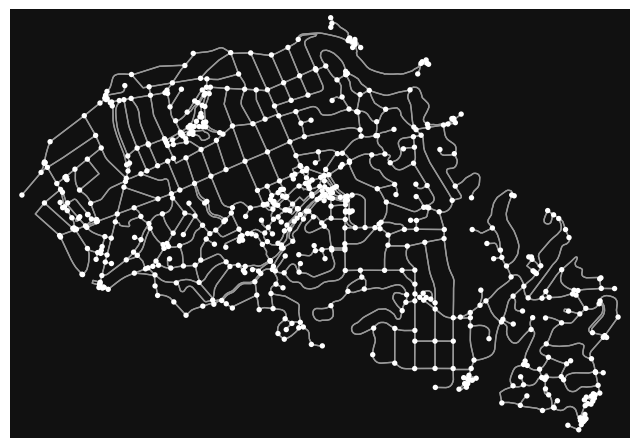

In [3]:
# download/model a street network for some city then visualize it
G = ox.graph_from_place("Piedmont, California, USA", network_type="walk")
fig, ax = ox.plot_graph(G)

OSMnx geocodes the query "Piedmont, California, USA" to retrieve the place boundaries of that city from the Nominatim API, retrieves the drivable street network data within those boundaries from the Overpass API, constructs a graph model, then simplifies/corrects its topology such that nodes represent intersections and dead-ends and edges represent the street segments linking them. All of this is discussed in detail in the documentation and these examples.

OSMnx models all networks as NetworkX `MultiDiGraph` objects. You can convert to:
  - undirected MultiGraphs
  - DiGraphs without (possible) parallel edges
  - GeoPandas node/edge GeoDataFrames

In [4]:
# convert your MultiDiGraph to an undirected MultiGraph
M = ox.utils_graph.get_undirected(G)

# convert your MultiDiGraph to a DiGraph without parallel edges
D = ox.utils_graph.get_digraph(G)

In [5]:
# you can convert your graph to node and edge GeoPandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_nodes.head()

,y,x,street_count,highway,geometry
osmid,,,,,
53017091,37.826250,-122.247604,3,NaN,POINT (-122.24760 37.82625)
53018397,37.824224,-122.247194,3,NaN,POINT (-122.24719 37.82422)
53018399,37.824918,-122.246080,3,NaN,POINT (-122.24608 37.82492)
53018402,37.825406,-122.245317,3,NaN,POINT (-122.24532 37.82541)
53018404,37.825948,-122.244467,3,NaN,POINT (-122.24447 37.82595)


In [6]:
gdf_edges.head()

osmid          name      highway  oneway  \
u        v          key                                                 
53017091 53064327   0      6345781   Rose Avenue  residential   False   
         9949655076 0      6345781   Rose Avenue  residential   False   
53018397 53097980   0    196739937  Linda Avenue     tertiary   False   
         9125570959 0      6327298   Lake Avenue  residential   False   
         53018411   0    196739937  Linda Avenue     tertiary   False   

                        reversed   length  \
u        v          key                     
53017091 53064327   0      False  231.335   
         9949655076 0       True  113.683   
53018397 53097980   0       True  100.767   
         9125570959 0      False   54.964   
         53018411   0      False   37.803   

                                                                  geometry  \
u        v          key                                                      
53017091 53064327   0    LINESTRING (-122.24760 37.82625, -122.24551 37...   
         9949655076 0    LINESTRING (-122.24760 37.82625, -122.24770 37...   
53018397 53097980   0    LINESTRING (-122.24719 37.82422, -122.24777 37...   
         9125570959 0    LINESTRING (-122.24719 37.82422, -122.24712 37...   
         53018411   0    LINESTRING (-122.24719 37.82422, -122.24713 37...   

                        lanes service maxspeed junction access bridge width  
u        v          key                                                      
53017091 53064327   0     NaN     NaN      NaN      NaN    NaN    NaN   NaN  
         9949655076 0     NaN     NaN      NaN      NaN    NaN    NaN   NaN  
53018397 53097980   0     NaN     NaN      NaN      NaN    NaN    NaN   NaN  
         9125570959 0     NaN     NaN      NaN      NaN    NaN    NaN   NaN  
         53018411   0     NaN     NaN      NaN      NaN    NaN    NaN   NaN

You can create a graph from node/edge GeoDataFrames, as long as gdf_nodes is indexed by osmid and gdf_edges is multi-indexed by u, v, key (following normal MultiDiGraph structure). This allows you to load graph node/edge shapefiles or GeoPackage layers as GeoDataFrames then convert to a MultiDiGraph for graph analytics.

In [7]:
# convert node/edge GeoPandas GeoDataFrames to a NetworkX MultiDiGraph
G2 = ox.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=G.graph)

## Basic street network stats

In [8]:
# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

4266225.16853353

In [9]:
# show some basic stats about the network
ox.basic_stats(G_proj, area=graph_area_m, clean_int_tol=15)

{'n': 689,
 'm': 1912,
 'k_avg': 5.550072568940493,
 'edge_length_total': 145059.70200000037,
 'edge_length_avg': 75.86804497907968,
 'streets_per_node_avg': 2.86066763425254,
 'streets_per_node_counts': {0: 0, 1: 94, 2: 0, 3: 508, 4: 83, 5: 3, 6: 1},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.13642960812772134,
  2: 0.0,
  3: 0.737300435413643,
  4: 0.1204644412191582,
  5: 0.0043541364296081275,
  6: 0.001451378809869376},
 'intersection_count': 595,
 'street_length_total': 72529.85099999994,
 'street_segment_count': 956,
 'street_length_avg': 75.86804497907943,
 'circuity_avg': 1.0895672757433479,
 'self_loop_proportion': 0.0020920502092050207,
 'clean_intersection_count': 361,
 'node_density_km': 161.50108650660755,
 'intersection_density_km': 139.46755656230988,
 'edge_density_km': 34001.886039658595,
 'street_density_km': 17000.94301982924,
 'clean_intersection_density_km': 84.6181309562922}

stats documentation: https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats

In [10]:
# save graph to disk as geopackage (for GIS) or graphml file (for gephi etc)
ox.save_graph_geopackage(G, filepath="./data/mynetwork.gpkg")
ox.save_graphml(G, filepath="./data/mynetwork.graphml")

## Visualize street centrality

Here we plot the street network and color its edges (streets) by their relative closeness centrality.

In [11]:
# convert graph to line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(G))
nx.set_edge_attributes(G, edge_centrality, "edge_centrality")

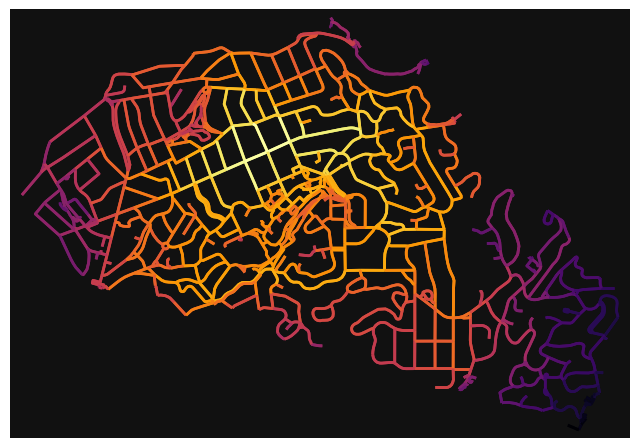

In [12]:
# color edges in original graph with closeness centralities from line graph
ec = ox.plot.get_edge_colors_by_attr(G, "edge_centrality", cmap="inferno")
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=2, node_size=0)

## Routing

In [13]:
# impute missing edge speeds and calculate edge travel times with the speed module
G = ox.speed.add_edge_speeds(G)
G = ox.speed.add_edge_travel_times(G)

In [14]:
# get the nearest network nodes to two lat/lng points with the distance module
orig = ox.distance.nearest_nodes(G, X=-122.245846, Y=37.828903)
dest = ox.distance.nearest_nodes(G, X=-122.215006, Y=37.812303)

In [15]:
orig

53075602

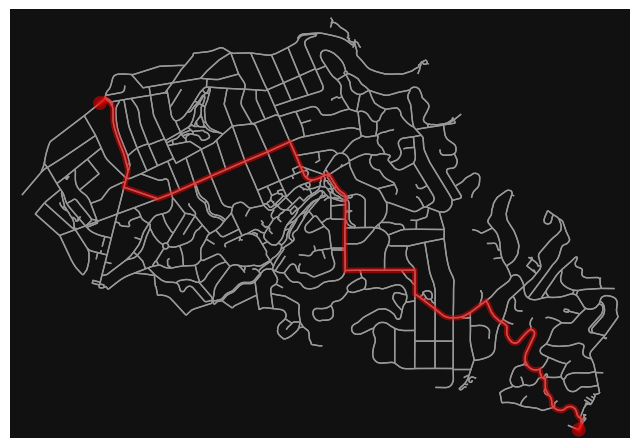

In [16]:
# find the shortest path between nodes, minimizing travel time, then plot it
route = ox.shortest_path(G, orig, dest, weight="travel_time")
fig, ax = ox.plot_graph_route(G, route, node_size=0)

In [17]:
# how long is our route in meters?
edge_lengths = ox.utils_graph.get_route_edge_attributes(G, route, "length")
round(sum(edge_lengths))

4553

In [18]:
# how far is it between these two nodes as the crow flies?
# use OSMnx's vectorized great-circle distance (haversine) function
orig_x = G.nodes[orig]["x"]
orig_y = G.nodes[orig]["y"]
dest_x = G.nodes[dest]["x"]
dest_y = G.nodes[dest]["y"]
round(ox.distance.great_circle_vec(orig_y, orig_x, dest_y, dest_x))

3124

You can add elevation attributes to your graph's nodes automatically with the `elevation` module, using either local raster files or the Google Maps Elevation API.

In [19]:
# add elevation to nodes automatically, calculate edge grades, plot network
# you need a google elevation api key to run this cell!
try:
    from keys import google_elevation_api_key

    G = ox.elevation.add_node_elevations_google(G, api_key=google_elevation_api_key)
    G = ox.elevation.add_edge_grades(G)
    nc = ox.plot.get_node_colors_by_attr(G, "elevation", cmap="plasma")
    fig, ax = ox.plot_graph(G, node_color=nc, node_size=20, edge_linewidth=2, edge_color="#333")
except ImportError:
    print("You need a google_elevation_api_key to run this cell.")

You need a google_elevation_api_key to run this cell.


Nodes are colored from lowest elevation (dark blue) to highest (bright yellow).

Example: create [elevation-based](12-node-elevations-edge-grades.ipynb) impedance functions to route around hills.

## Get networks other ways

make queries less ambiguous to help the geocoder out, if it's not finding what you're looking for

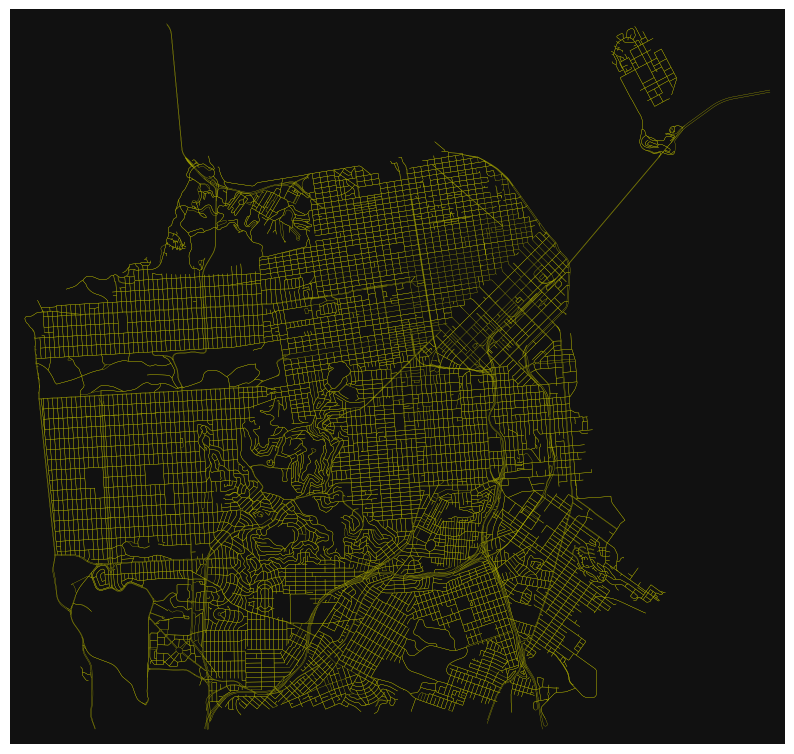

In [20]:
# you can make query an unambiguous dict to help the geocoder find it
place = {"city": "San Francisco", "state": "California", "country": "USA"}
G = ox.graph_from_place(place, network_type="drive", truncate_by_edge=True)
fig, ax = ox.plot_graph(G, figsize=(10, 10), node_size=0, edge_color="y", edge_linewidth=0.2)

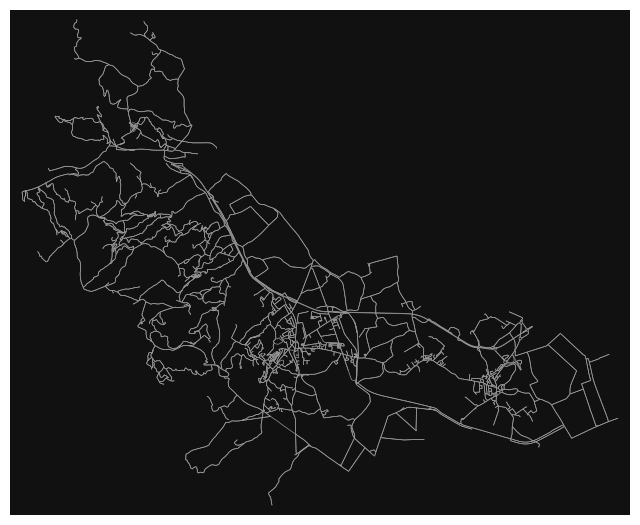

In [21]:
# you can get networks anywhere in the world
G = ox.graph_from_place("Sinalunga, Italy", network_type="all")
fig, ax = ox.plot_graph(G, node_size=0, edge_linewidth=0.5)

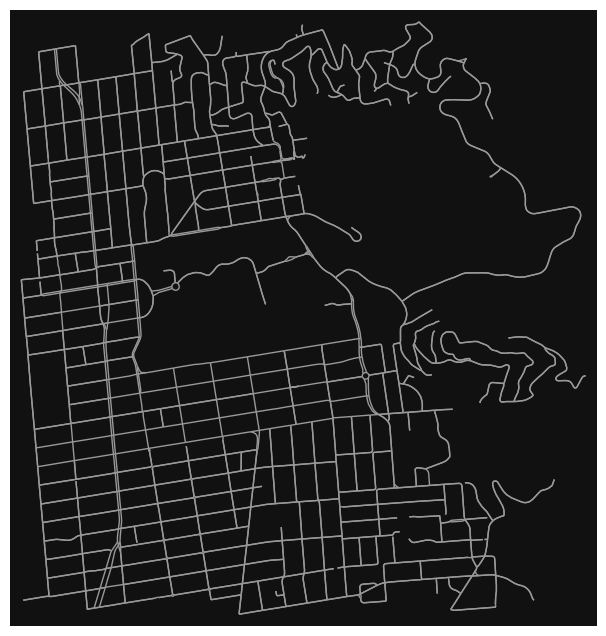

In [22]:
# or get network by address, coordinates, bounding box, or any custom polygon
# ...useful when OSM just doesn't already have a polygon for the place you want
wurster_hall = (37.870605, -122.254830)
one_mile = 1609  # meters
G = ox.graph_from_point(wurster_hall, dist=one_mile, network_type="drive")
fig, ax = ox.plot_graph(G, node_size=0)

Examples of [getting networks](01-overview-osmnx.ipynb) by coordinates, bounding box, or any custom polygon shape.

## Get other networked infrastructure types

...like rail or electric grids or even the canals of Venice and Amsterdam, using the `custom_filter` parameter: [see more examples](08-custom-filters-infrastructure.ipynb).

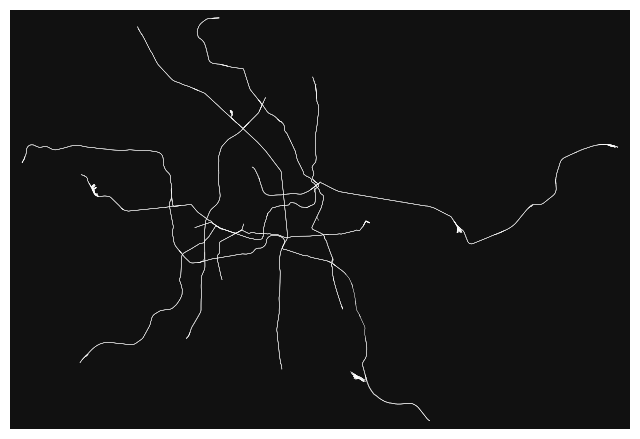

In [23]:
# get NY subway rail network
G = ox.graph_from_place(
    "Berlin, DE", 
    retain_all=False,
    truncate_by_edge=True,
    simplify=True,
    custom_filter='["railway"~"subway"]',
)

fig, ax = ox.plot_graph(G, node_size=0, edge_color="w", edge_linewidth=0.2)

## Get any geospatial entities' geometries and attributes

Use the `geometries` module to download entities, such as local amenities, points of interest, or building footprints, and turn them into a GeoDataFrame: [see docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.geometries). For more usage examples of downloading geospatial objects from OSM, see [this notebook](16-download-osm-geospatial-entities.ipynb).

In [24]:
# get all building footprints in some neighborhood
place = "Kreuzberg, Berlin, Germany"


In [25]:
tags = {"building": True}
gdf = ox.geometries_from_place(place, tags)
gdf.shape

(8248, 235)

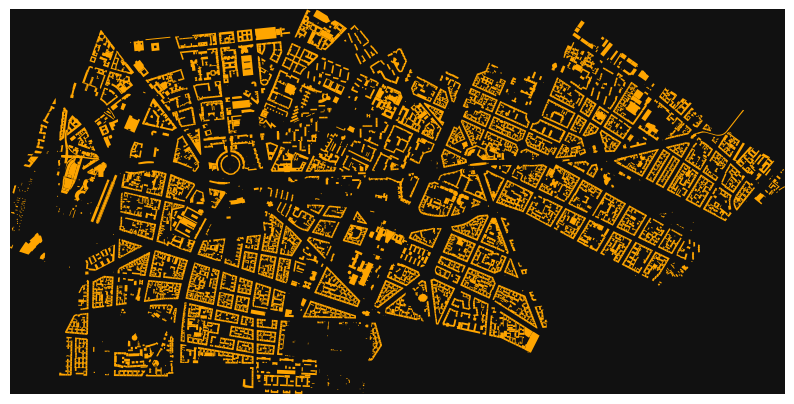

In [26]:
fig, ax = ox.plot_footprints(gdf, figsize=(10, 10))

In [27]:
gdf['building:levels']

element_type  osmid     
node          294503248     NaN
              8251911925      1
              8853796417      1
              9141403800      1
              9272714003      1
                           ... 
relation      12444329        6
              13502286        6
              14376902        8
              14390995        5
              14587479        7
Name: building:levels, Length: 8248, dtype: object

See the other notebooks for more examples of visualization with OSMnx.

In [28]:
# get all parks and bus stops in some neighborhood
tags = {"leisure": "park", "highway": "bus_stop"}
gdf_2 = ox.geometries_from_place(place, tags)
gdf_2.shape

(263, 64)

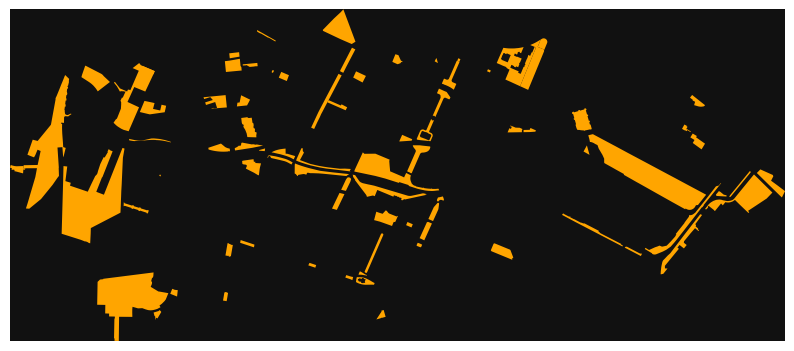

In [29]:
fig, ax = ox.plot_footprints(gdf_2, figsize=(10, 10))

In [30]:
gdf_2

name  \
element_type osmid                                           
node         296094695  Manteuffelstraße/Köpenicker Straße   
             296094887  Manteuffelstraße/Köpenicker Straße   
             296095058                       Bethaniendamm   
             296095562                     Eisenbahnstraße   
             296095564                     Eisenbahnstraße   
...                                                    ...   
relation     3582343        Park am Gleisdreieck - Ostpark   
             14236112                   Schlesischer Busch   
             14282253                  Wassertorplatz Nord   
             14282254                         Oranienplatz   
             14349157                            Bethanien   

                                                                  website  \
element_type osmid                                                          
node         296094695                                                NaN   
             296094887                                                NaN   
             296095058                                                NaN   
             296095562                                                NaN   
             296095564                                                NaN   
...                                                                   ...   
relation     3582343    https://gruen-berlin.de/parks-gaerten/park-am-...   
             14236112                                                 NaN   
             14282253                                                 NaN   
             14282254                                                 NaN   
             14349157                                                 NaN   

                       wheelchair  \
element_type osmid                  
node         296094695        NaN   
             296094887        NaN   
             296095058        NaN   
             296095562        NaN   
             296095564        NaN   
...                           ...   
relation     3582343          NaN   
             14236112         NaN   
             14282253         NaN   
             14282254         NaN   
             14349157         NaN   

                                                                 geometry  \
element_type osmid                                                          
node         296094695                          POINT (13.43184 52.50552)   
             296094887                          POINT (13.43191 52.50586)   
             296095058                          POINT (13.42862 52.50730)   
             296095562                          POINT (13.43454 52.50455)   
             296095564                          POINT (13.43531 52.50440)   
...                                                                   ...   
relation     3582343    POLYGON ((13.37580 52.49527, 13.37622 52.49581...   
             14236112   MULTIPOLYGON (((13.44457 52.49410, 13.44488 52...   
             14282253   POLYGON ((13.41250 52.49880, 13.41247 52.49881...   
             14282254   MULTIPOLYGON (((13.41510 52.50179, 13.41508 52...   
             14349157   POLYGON ((13.42242 52.50301, 13.42248 52.50310...   

                       access barrier bench  bin  bus   highway  ... reg_name  \
element_type osmid                                               ...            
node         296094695    NaN     NaN   yes  yes  yes  bus_stop  ...      NaN   
             296094887    NaN     NaN   yes  yes  yes  bus_stop  ...      NaN   
             296095058    NaN     NaN   yes  yes  yes  bus_stop  ...      NaN   
             296095562    NaN     NaN   yes  yes  yes  bus_stop  ...      NaN   
             296095564    NaN     NaN   yes   no  yes  bus_stop  ...      NaN   
...                       ...     ...   ...  ...  ...       ...  ...      ...   
relation     3582343      NaN     NaN   NaN  NaN  NaN       NaN  ...      NaN   
             14236112     NaN   

In [31]:
tags = {"amenity": "bar", "amenity": "cafe", "amenity": "restaurant"}
gdf_3 = ox.geometries_from_place(place, tags)
gdf_3.shape

(401, 127)

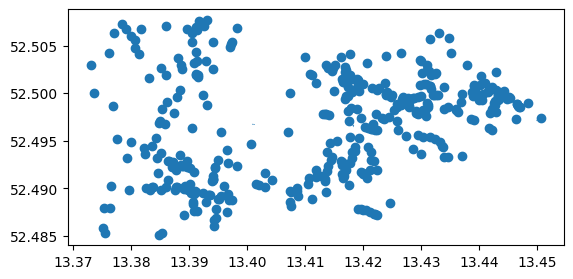

In [32]:
ax = gdf_3.plot()

In [33]:
gdf_3.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

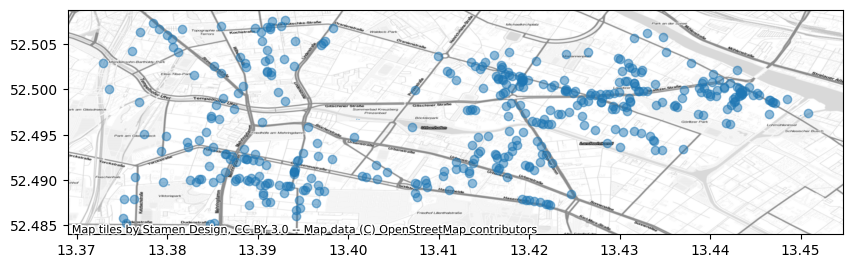

In [34]:
import contextily as cx
ax = gdf_3.plot(figsize=(10, 10), alpha=0.5)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite, crs=gdf_3.crs)
ax

In [35]:
gdf_3

addr:city addr:country addr:housenumber addr:postcode  \
element_type osmid                                                             
node         30020303     Berlin           DE               19         10961   
             258398258       NaN          NaN              NaN           NaN   
             267412672       NaN          NaN              NaN           NaN   
             272811395    Berlin           DE               64         10997   
             272820430    Berlin           DE                2         10997   
...                          ...          ...              ...           ...   
way          106743083    Berlin           DE               44         10999   
             124850918    Berlin           DE               62         10965   
             133778314    Berlin           DE               30         10961   
             235843126    Berlin           DE                2         10997   
             310847569    Berlin          NaN               80         10965   

                                     addr:street addr:suburb     amenity  \
element_type osmid                                                         
node         30020303            Zossener Straße   Kreuzberg  restaurant   
             258398258                       NaN         NaN  restaurant   
             267412672                       NaN         NaN  restaurant   
             272811395          Skalitzer Straße   Kreuzberg  restaurant   
             272820430  Vor dem Schlesischen Tor   Kreuzberg  restaurant   
...                                          ...         ...         ...   
way          106743083         Kohlfurter Straße   Kreuzberg  restaurant   
             124850918           Kreuzbergstraße   Kreuzberg  restaurant   
             133778314            Carl-Herz-Ufer   Kreuzberg  restaurant   
             235843126  Vor dem Schlesischen Tor   Kreuzberg  restaurant   
             310847569               Mehringdamm         NaN  restaurant   

                           contact:phone          cuisine diet:vegan  ...  \
element_type osmid                                                    ...   
node         30020303     +49 30 6948948          tibetan        yes  ...   
             258398258               NaN              NaN        NaN  ...   
             267412672               NaN          chicken        NaN  ...   
             272811395               NaN              NaN        NaN  ...   
             272820430   +49 30 61074309              NaN        NaN  ...   
...                                  ...              ...        ...  ...   
way          106743083               NaN        ethiopian        yes  ...   
             124850918               NaN              NaN        NaN  ...   
             133778314  +49 30 692 33 00  regional;german        NaN  ...   
             235843126               NaN              NaN        NaN  ...   
             310847569               NaN         regional        NaN  ...   

                           building building:levels heritage  \
element_type osmid                                             
node         30020303           NaN             NaN      NaN   
             258398258          NaN             NaN      NaN   
             267412672          NaN             NaN      NaN   
             272811395          NaN             NaN      NaN   
             272820430          NaN             NaN      NaN   
...                             ...             ...      ...   
way          106743083   apartments               5      NaN   
             124850918  residential             NaN      NaN   
             133778314       retail               1      NaN   
             235843126   commercial               2        4   
             310847569          yes             NaN      NaN   

                       heritage:operator  \
element_type osmid                         
node         30020303                NaN   
             258398258    

In [36]:
list(gdf_3.columns)

['addr:city',
 'addr:country',
 'addr:housenumber',
 'addr:postcode',
 'addr:street',
 'addr:suburb',
 'amenity',
 'contact:phone',
 'cuisine',
 'diet:vegan',
 'indoor_seating',
 'name',
 'opening_hours',
 'outdoor_seating',
 'wheelchair',
 'geometry',
 'website',
 'bar',
 'contact:website',
 'opening_hours:kitchen',
 'contact:email',
 'toilets:wheelchair',
 'level',
 'toilets',
 'email',
 'fax',
 'phone',
 'smoking',
 'wheelchair:description',
 'check_date:opening_hours',
 'cocktails',
 'diet:vegetarian',
 'drink:beer',
 'drink:liquor',
 'drink:wine',
 'contact:fax',
 'internet_access',
 'seating',
 'brewery',
 'contact:facebook',
 'delivery',
 'description',
 'name:en',
 'takeaway',
 'operator',
 'url',
 'payment:apple_pay',
 'payment:cash',
 'payment:contactless',
 'payment:debit_cards',
 'payment:diners_club',
 'payment:mastercard',
 'payment:visa',
 'website:menu',
 'payment:credit_cards',
 'opening_hours:signed',
 'layer',
 'craft',
 'shop',
 'access:covid19',
 'check_date',
 'de

In [37]:
gdf_poligons = gdf_3.loc['way']
gdf_poligons.reset_index(inplace=True)

In [38]:
import folium
m = folium.Map(location=[
  gdf_poligons.geometry[0].centroid.y,#lat
  gdf_poligons.geometry[0].centroid.x,#lon
], zoom_start=18)
m.choropleth(gdf_poligons, data=gdf_poligons,columns=['name','geometry'], fill_color='YlOrBr')

/home/laia/.pyenv/versions/3.8.12/envs/livablestreetsenv/lib/python3.8/site-packages/folium/folium.py:407: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


In [39]:
m

In [42]:
m2 = folium.Map(location=[
  gdf_3.geometry[0].centroid.y,#lat
  gdf_3.geometry[0].centroid.x,#lon
], zoom_start=18)
m2.choropleth(gdf_3, fill_color='YlOrBr')
m2

/home/laia/.pyenv/versions/3.8.12/envs/livablestreetsenv/lib/python3.8/site-packages/folium/folium.py:407: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


In [ ]:
gdf_3['geometry'].loc['way'] = gdf_3['geometry'].apply(lambda x: x.centroid)

In [ ]:
gdf_3[['name','geometry']]

name  \
element_type osmid                                           
node         30020303                           Tibet Haus   
             258398258                Wirtshaus Hasenheide   
             267412672  Die Henne - Alt-Berliner Wirtshaus   
             272811395                               Kante   
             272820430            Restaurant Freischwimmer   
...                                                    ...   
way          106743083                             Langano   
             124850918                              Tomasa   
             133778314                      Altes Zollhaus   
             235843126                              Anhalt   
             310847569                        Dolden-Mädel   

                                         geometry  
element_type osmid                                 
node         30020303   POINT (13.39398 52.49071)  
             258398258  POINT (13.41966 52.48779)  
             267412672  POINT (13.41775 52.50415)  
             272811395  POINT (13.43879 52.50013)  
             272820430  POINT (13.45080 52.49735)  
...                                           ...  
way          106743083  POINT (13.41832 52.49655)  
             124850918  POINT (13.38021 52.48946)  
             133778314  POINT (13.40109 52.49671)  
             235843126  POINT (13.45001 52.49713)  
             310847569  POINT (13.38591 52.48954)  

[401 rows x 2 columns]